# Task 1 Web scraping and analysis


## Step 1 : Collect the Web Data

### Scraping data from Skytrax

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [58]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [59]:
df = pd.DataFrame()
df["reviews"] = reviews

In [60]:
#df.to_csv("data/BA_reviews.csv")

In [61]:
#df = df.read_csv("data/BA_reviews.csv")

## Step 2: Clean the Data

In [62]:
# Change to lower case
df['reviews'] = df['reviews'].str.lower()

# Clear whitespace
df['reviews'] = df['reviews'].str.strip()

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"  # additional symbols
                                u"\U000024C2-\U0001F251"  # enclosed characters
                                "]+", flags=re.UNICODE)
    cleaned_text = emoji_pattern.sub(r'', text)
    return cleaned_text

# Apply remove_emoji(text) to the reviews column
df['reviews'] = df['reviews'].apply(lambda x: remove_emoji(x))

In [64]:
def regex_clean(text):
    regex_to_clean = [
        r'(@.+?)\s',        # Matches mentions like @username followed by a space
        r'\s\d+\s',         # Matches numbers surrounded by spaces
        r'\s?\d+\.',        # Matches numbers followed by a dot, optionally preceded by space
    ]
    for reg in regex_to_clean:
        cleaned_text = re.sub(reg, "", text)  # Sequentially clean the text with each regex
    return cleaned_text

# Apply regex_clean(text) to reviews column
df['reviews'] = df['reviews'].apply(lambda x: regex_clean(x))

In [65]:
def remove_stopwords(text):
    blob = TextBlob(text)
    cleaned_words = [word for word in blob.words if word.lower() not in STOPWORDS]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply remove_stopwords(text) to review column
df['reviews'] = df['reviews'].apply(lambda x: remove_stopwords(x))

In [78]:
def remove_unwanted(text):
   unwanted = ["verified", "trip verified"]
   blob = TextBlob(text)
   cleaned_words = [word for word in blob.words if word.lower() not in unwanted and len(word)>2]
   cleaned_text = ' '.join(cleaned_words)
   return cleaned_text
   
# Apply remove_unwanted(text) to reviews columns
df['reviews'] = df['reviews'].apply(lambda x: remove_unwanted(x))

In [79]:
df['reviews']

0      good points cabin crew helpful professional ma...
1      decent flight reasonable comfortable seat pilo...
2      trip really flying british airways particularl...
3      trip book online night system arrived early ai...
4      trip rough experiences recent years look forwa...
                             ...                        
995    trip flying london city geneva plus embraer e1...
996    trip los angeles istanbul via london flight lo...
997    trip phoenix tel aviv via london return london...
998    london kefalonia galleries lounge showing age ...
999    trip london dublin never choice fly british ai...
Name: reviews, Length: 1000, dtype: object

## Step 3: Analyse the Data

### 1. Wordcloud Analysis

In [80]:
# Combine all reviews into one string
all_reviews = ' '.join(df['reviews'])

In [ ]:
# Create a WordCloud object

wc = WordCloud(
               background_color='white',
               mask=np.array(Image.open("data/British-Airways-Symbol.png"))
              ).generate(all_reviews)

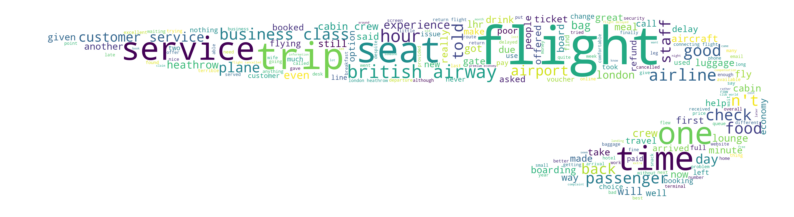

In [84]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2. Sentiment Analysis

In [86]:
df['polarity score'] = df['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head()

,reviews,polarity score,polarity
0,good points cabin crew helpful professional ma...,0.047050,Positive
1,decent flight reasonable comfortable seat pilo...,0.219524,Positive
2,trip really flying british airways particularl...,0.236645,Positive
3,trip book online night system arrived early ai...,-0.150000,Negative
4,trip rough experiences recent years look forwa...,0.116667,Positive


In [87]:
def get_polarity(score): 
   if score > 0:
       return "Positive"
   elif score < 0:
       return "Negative"
   else:
       return "Neutral"
df['polarity'] = df['polarity score'].apply(lambda x: get_polarity(x))

In [88]:
df["polarity"].value_counts(normalize=1)

polarity
Positive    0.624
Negative    0.359
Neutral     0.017
Name: proportion, dtype: float64

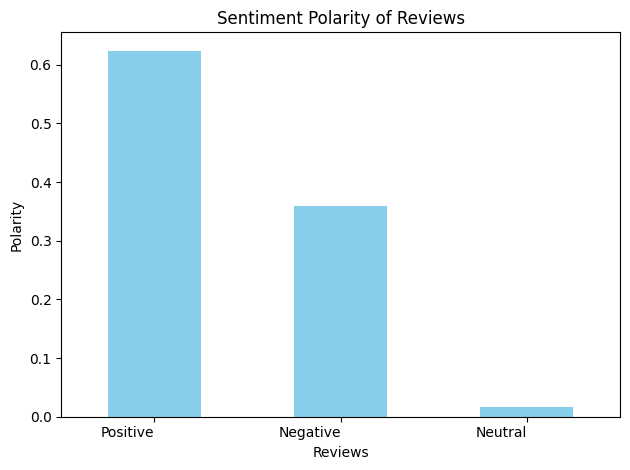

In [89]:
# Plot the sentiment polarity 
df["polarity"].value_counts(normalize=1).plot(kind='bar', color='skyblue')
plt.title('Sentiment Polarity of Reviews') 
plt.xlabel('Reviews') 
plt.ylabel('Polarity')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()